In [2]:
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.preprocessing.image import img_to_array
from keras._tf_keras.keras.utils import to_categorical, plot_model
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

Hi


In [3]:
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3) # Height, width, num of RGB channels


In [4]:
#glob is a module that is used to read images from dataset and store in an array
data = []
labels = []

# Reading in images from dataset
# Bigger dataset: /Users/vasudevnair113/Downloads/faceRecog/archive
# Bigger dataset: /Users/vasudevnair113/Downloads/faceRecog/archiveSmall2

image_files = [f for f in glob.glob(r'C:/Users/user/Desktop/AIM project/asl_alphabet_train-20241016T002347Z-001 (1)/asl_alphabet_train' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)


In [5]:
# converts image to numpy array. resizes image to same size.
# assigns alphabets to images
# Adds images to array, also gives it a label (1 = female, 0 = male)
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1])) # Resizes every image to be the same size
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    label = ord(label) - ord('A') # Convert label to numerical value (0-25)
    labels.append([label])

# Data pre-processing, converts data and labels to numpy array
try:
    data = np.array(data, dtype='float') / 255.0
    labels = np.array(labels)
except Exception as e:
    print(f"Error converting data to numpy array: {e}")

In [6]:
# 53-54, converting images to a format easy to understand, converting labels array into a format that is easy to understand.
# augmentation used to create altered version of trained data, thats the purpose of data augmentation
# Splits dataset into training and testing
# test_size = 0.2 means that 20% of the dataset will be used for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=26)
testY = to_categorical(testY, num_classes=26)

# Augmentation of dataset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

In [7]:
'''
lines 60-111, we r working on the main neural network.
-1 : channels come last
The filters/kernels slide over the image , like the eyes of a cat. the filters result in feature maps and decides which patterns to pass to next layer.
Max Pooling reduces image size by only taking the required points. reduces unwanted values or noise. like in an image of a person, it eliminates the background. only takes the max values.Dropout similar to Maxpooling is only done in some layers. Forces the model to work better.
Dropout similar to Maxpooling is only done in some layers. Forces the model to work better.
from line 85, some lines are commented out because otherwise it will take 6 hours to run your CNN.
line 102, flatten layer takes all those layers and flattens it into flat layer. Then
'''


# Height and width of image (96 x 96)
# Depth is RGB values
# Classes is number of categories (2 in our case because male/female)
def build(height, width, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # Need to check whether channels are first or last
    if K.image_data_format() == 'channels_first':
        inputShape = (depth, height, width)
        chanDim = 1

    # Adding convolution layer
    model.add(Conv2D(32, (3,3), padding='same', input_shape=inputShape)) # 32 filters, 3x3 image
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim)) # Normalizing the values
    # (Some data points may have high value, others may be low, causing the higher values to overshadow the lower values)
    # Max pooling, done to reduce unwanted values AKA noise in data set
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25)) # Prevents overfitting

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    '''
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    '''
    model.add(Flatten()) # Flattened so our layers are 1D to be passed into dense layer
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation('softmax')) # Sigmoid act func in output layer bc it's probability based

    return model

In [8]:
# Builds the model
model = build(width = img_dims[0], height = img_dims[1], depth = img_dims[2], classes = 26)

# Compiles the model
opt = Adam(learning_rate = lr, decay = lr/epochs)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

# Trains the model
H = model.fit(aug.flow(trainX, trainY, batch_size = batch_size), validation_data = (testX,testY),
                        steps_per_epoch = len(trainX) // batch_size, epochs = epochs, verbose = 1)

# Saves model to the disk
model.save('sign_language_detection.keras')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.1699 - loss: 4.4559 - val_accuracy: 0.0274 - val_loss: 5.5005
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 717ms/step - accuracy: 0.4531 - loss: 2.1977

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.4531 - loss: 2.1977 - val_accuracy: 0.0274 - val_loss: 5.9340
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 715ms/step - accuracy: 0.4499 - loss: 2.2552 - val_accuracy: 0.0137 - val_loss: 6.6212
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.3750 - loss: 2.2629 - val_accuracy: 0.0137 - val_loss: 6.6513
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 706ms/step - accuracy: 0.5295 - loss: 1.7194 - val_accuracy: 0.0137 - val_loss: 5.5035
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5000 - loss: 1.7552 - val_accuracy: 0.0137 - val_loss: 5.1397
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 712ms/step - accuracy: 0.5813 - loss: 1.5335 - val_accuracy: 0.0137 - val_loss: 4.2451
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5000 - loss: 1.4503 - val_accuracy: 0.0137 - val_loss: 4.2263
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 652ms/step - accuracy: 0.6249 - loss: 1.2350 - val_accuracy: 0.0137 - val_loss: 4.1472


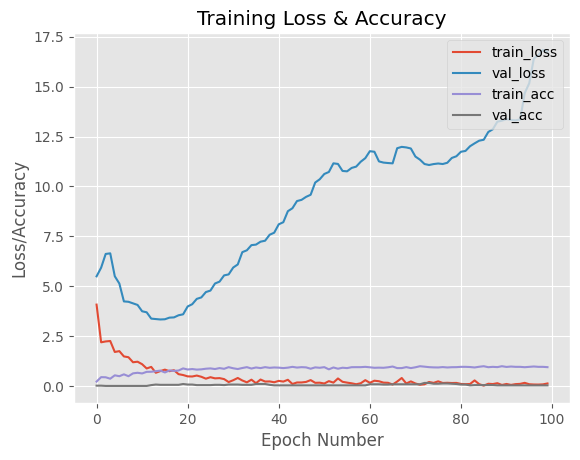

In [9]:
# Plot the training and validation loss and accuracy

plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss & Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')